# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [16]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPu

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,5.028689e-01,4.028818e-01,9.854712e-02,3.752564e-01,5.918652e-02,4.195026e-01,1.184329e-01,2.984282e-01,1.689049e-01,1.431109e-01,...,1.145499e-02,1.968431e-02,7.960149e-02,1.344227e-01,9.530649e-03,1.751597e-02,8.878922e-02,7.431632e-02,3.897225e-02,5.331061e-02
std,4.710872e-01,4.523492e-01,2.907154e-01,4.479614e-01,2.284392e-01,2.256374e-01,7.151420e-02,1.867567e-01,1.842988e-01,1.868169e-01,...,5.399123e-02,8.007008e-02,1.179461e-01,1.749526e-01,5.258238e-02,8.241773e-02,1.050750e-01,9.861962e-02,9.868933e-02,1.123964e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,1.658186e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.774194e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433434e-01,7.525668e-02,2.972268e-01,9.318519e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,5.416341e-02,3.541864e-02,0.000000e+00,0.000000e+00
75%,1.000000e+00,9.390244e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.860562e-01,1.505134e-01,4.382091e-01,3.095545e-01,2.756683e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.365586e-01,1.118571e-01,0.000000e+00,4.670041e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [17]:
# FTC selection

df = df[df[ftc_key] == True]
df = df.drop([ftc_key], axis=1)
independent_fields = [field for field in independent_fields if field != ftc_key]
print(len(df))

426950


In [18]:
# Drops all ecosystem fields.

from python_proj.utils.util import get_matching

dropped_fields = list(get_matching(independent_fields, r'(.*(?=Dependency).*|.*Weighted.*|.*LinkIntensity.*)'))
print(f'{len(dropped_fields)=}')
print(f'{dropped_fields=}')

df = df.drop(dropped_fields, axis=1)
independent_fields = [field for field in independent_fields if field not in dropped_fields]

df.describe()

len(dropped_fields)=19
dropped_fields=['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + I

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount)
count,4.269500e+05,4.269500e+05,426950.000000,426950.0,426950.000000,426950.000000,426950.000000,426950.000000,426950.0,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000
mean,1.213611e+08,5.135208e+06,583.468856,0.0,0.265369,0.491555,0.106444,0.198750,0.0,0.005998,0.090836,0.097105,0.011796,0.016796,0.060232,0.098381
std,9.542074e+07,8.019043e+06,1718.982599,0.0,0.409419,0.223162,0.061022,0.165111,0.0,0.033875,0.154899,0.175581,0.038799,0.055423,0.104373,0.153506
min,1.153000e+03,1.000000e+00,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.800664e+07,4.989098e+05,30.000000,0.0,0.000000,0.334494,0.075257,0.082909,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.010847e+08,1.681994e+06,122.000000,0.0,0.000000,0.503086,0.075257,0.165819,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.890214e+08,6.317507e+06,470.000000,0.0,0.666667,0.662209,0.119279,0.306801,0.0,0.000000,0.100113,0.153254,0.000000,0.000000,0.089382,0.155067
max,3.617726e+08,5.973444e+07,82976.000000,0.0,1.000000,1.000000,1.000000,0.992403,0.0,0.729293,0.979244,1.000000,0.829546,0.907261,1.000000,1.000000


In [19]:
# Drops all intra-project pull request fields.

from python_proj.utils.util import get_matching

dropped_fields = [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
]

df = df.drop(dropped_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in dropped_fields
]

df.describe()

,ID,Submitter ID,PR Number,EcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount)
count,4.269500e+05,4.269500e+05,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000
mean,1.213611e+08,5.135208e+06,583.468856,0.265369,0.491555,0.106444,0.198750,0.005998,0.090836,0.097105,0.011796,0.016796,0.060232,0.098381
std,9.542074e+07,8.019043e+06,1718.982599,0.409419,0.223162,0.061022,0.165111,0.033875,0.154899,0.175581,0.038799,0.055423,0.104373,0.153506
min,1.153000e+03,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.800664e+07,4.989098e+05,30.000000,0.000000,0.334494,0.075257,0.082909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.010847e+08,1.681994e+06,122.000000,0.000000,0.503086,0.075257,0.165819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.890214e+08,6.317507e+06,470.000000,0.666667,0.662209,0.119279,0.306801,0.000000,0.100113,0.153254,0.000000,0.000000,0.089382,0.155067
max,3.617726e+08,5.973444e+07,82976.000000,1.000000,1.000000,1.000000,0.992403,0.729293,0.979244,1.000000,0.829546,0.907261,1.000000,1.000000


## Log-odds linearity


### Visual checking


untransformed
EcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.0
0.10    0.0
0.25    0.5
0.40    0.8
0.50    0.9
0.60    1.0
0.75    1.0
0.90    1.0
1.00    1.0
Name: EcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.0, 0.6666666666666666, 0.85, 1.0, 1.0, 1.0, 1.0], y=[0.3967120569959097, 0.4759734983947332, 0.8866616907935141, 1.2792958434578257, 1.1714011632035761, 1.086583175901426, 1.086583175901426, 1.086583175901426]
ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.334511
0.50    0.503102
0.75    0.662212
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.20332128038011463, 0.4298203571842806, 0.5797929779718054, 0.7609123791281821], y=[0.9072706341915084, 1.2717514172904059, 0.9109320905458479, -0.2985831066782089]
ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075257
0.25    0.075257
0.50    0.075257
0.75    0.119279
1.00    1.000000
Name: ln(1 + ControlNumberOfCommits

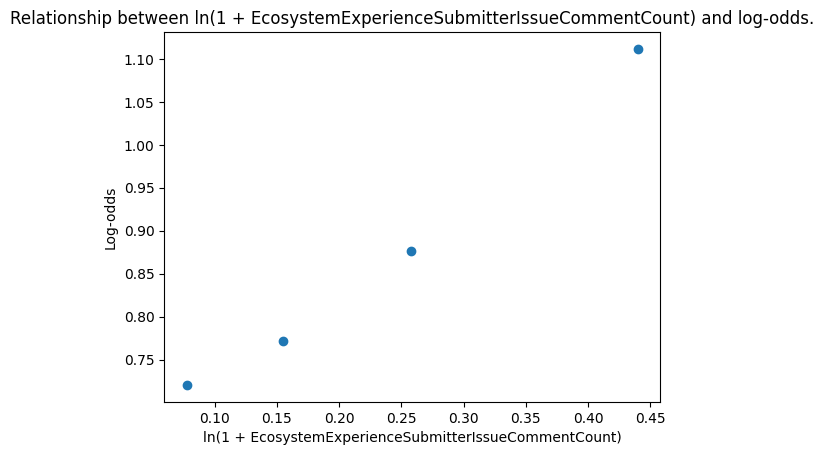

In [20]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Multicolinearity


In [21]:

# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounds
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",

    # n/a; these are filtered earlier already.
    # "IntraProjectSubmitterPullRequestSuccessRate",
    # "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",

    # eco
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",

    # intra-proj
    # "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 7 / 15 fields to account for multicollinearity.


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                            variable       VIF
0                        ControlIntegratedBySameUser  1.266752
1                      ControlPullRequestHasComments  4.189196
2         ControlPullRequestHasCommentByExternalUser  1.742092
3                     ControlHasHashTagInDescription  1.447621
4        ln(1 + ControlPullRequestLifeTimeInMinutes)  4.506021
5        ln(1 + ControlNumberOfCommitsInPullRequest)  3.506385
6  ln(1 + EcosystemExperienceSubmitterPullRequest...  1.285418
7  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.122891


In [23]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 0.
Problematic VIF scores:
Empty DataFrame
Columns: [variable, VIF]
Index: []


coof_threshold=0.5
Correlating pairs:
[]

Transitive closure of correlating pairs:
[
    []
]


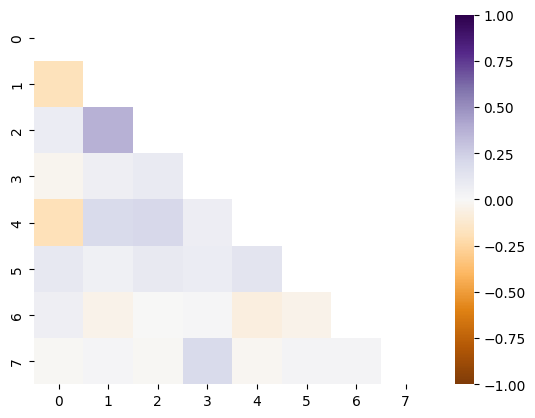

In [24]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
# print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


In [25]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    
    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))


In [26]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=8
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)'],
      dtype='object')


## Outliers

Using cook's distance.


In [27]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_45973/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_45973/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
619775,0.000309,4.380467
619757,0.000295,3.902683
619765,0.000286,3.394695
1111021,0.000279,3.092199
1110876,0.000250,5.973473
315285,0.000250,3.935178
484700,0.000241,5.608382
379168,0.000238,3.494215
1111381,0.000238,4.164821
1111234,0.000235,4.609726


9.368976041186019e-06
Found outliers: 4529 / 426950 (1.061%)


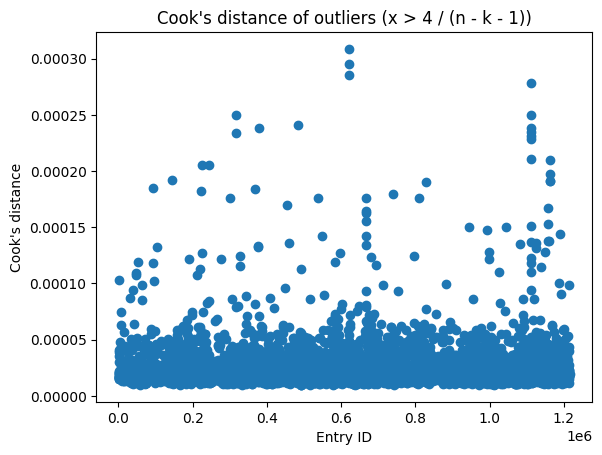

In [28]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [29]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=422421


# Model Creation

Creates a simple mixed effect logistic regression model.

In [30]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                          MixedLM               Dependent Variable:               PullRequestIsMerged
No. Observations:               422421                Method:                           REML               
No. Groups:                     20042                 Scale:                            0.1419             
Min. group size:                1                     Log-Likelihood:                   -232266.2471       
Max. group size:                505                   Converged:                        Yes                
Mean group size:                21.1                                                                       
-----------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                    -0.562    0.002 -317.044 0.000 -0.566 -0.559
ControlPullRequestHasComments                                  -0.155    0.002  -92.802 0.000 -0.159 -0.152
ControlPullRequestHasCommentByExternalUser                      0.024    0.002   14.936 0.000  0.021  0.027
ControlHasHashTagInDescription                                  0.044    0.001   31.174 0.000  0.041  0.046
ln(1 + ControlPullRequestLifeTimeInMinutes)                    -0.502    0.003 -161.811 0.000 -0.508 -0.496
ln(1 + ControlNumberOfCommitsInPullRequest)                     0.215    0.010   20.793 0.000  0.195  0.236
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)  0.385    0.004   87.459 0.000  0.376  0.394
ln(1 + IntraProjectSubmitterIssueSubmissionCount)               0.254    0.016   16.098 0.000  0.223  0.285
Group Var                                                       1.326    0.039                             
===========================================================================================================

"""

###

In [31]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f'Dependency Model: {field}'] = fields[field]

print(output)
dir_name = f'{base_path}/coefs/{file_name}/'
output_path = f'{dir_name}/coefs.csv'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
output.to_csv(output_path)


                                                   Dependency Model: Coef.   
ControlIntegratedBySameUser                                         -0.562  \
ControlPullRequestHasComments                                       -0.155   
ControlPullRequestHasCommentByExternalUser                           0.024   
ControlHasHashTagInDescription                                       0.044   
ln(1 + ControlPullRequestLifeTimeInMinutes)                         -0.502   
ln(1 + ControlNumberOfCommitsInPullRequest)                          0.215   
ln(1 + EcosystemExperienceSubmitterPullRequestS...                   0.385   
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                    0.254   
Group Var                                                            1.326   

                                                   Dependency Model: Std.Err.   
ControlIntegratedBySameUser                                             0.002  \
ControlPullRequestHasComments                            

In [32]:
import datetime

print(datetime.datetime.now())

2024-01-29 15:39:19.135645
